In [1]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 

In [3]:
from numba.typed import List
from numba import jit, njit, vectorize

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [5]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # (50/150) i.e 100 out of 150 are overlapping (number of skipped datapoints to start next window)
print(sliding_size)

16


# Feature sets

In [6]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 
@njit()
def get_rng(x):
    n = np.max(x)
    m = np.min(x)
    z = n-m
    return z 

def get_rms(x, axis=None):
    return np.sqrt(np.mean(x ** 2, axis=axis))

def calc_sma_for_window(data):
    return np.sum(data) / len(data)


def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))


def calc_absolutes_for_list(list):
    return ([abs(i) for i in list])

def get_sma(data): 
    sma_sim = calc_sma_for_window(data)
    sma_adv = calc_sma_adv_for_window(data)

    sma_sim_abs = calc_sma_for_window(calc_absolutes_for_list(data))
    sma_adv_abs = calc_sma_adv_for_window(calc_absolutes_for_list(data))

    return sma_sim, sma_adv, sma_sim_abs, sma_adv_abs

def get_entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

In [7]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

# Feature extraction and Vector_Normalization_and_mean_removal on signal

In [8]:
def Features(window):# mean, std,max,min and zero-crossing-rate
    wind = window.iloc[:, :-1]
    win = np.array(wind)
    
    data_normalized = preprocessing.normalize(win, norm  = 'l1') # normalization on signal
    win = data_normalized
    data_standardized = preprocessing.scale(win) # mean removal on signal
    win = data_standardized
    features = []
    
    features.append(get_mean(win))
    features.append(get_median(win))
    features.append(get_std(win))
    features.append(get_min(win))
    features.append(get_max(win))
    features.append(get_sum(win))
    features.append(get_entropy(win))
    mean_crossing = [mean_crossing_rate(win[:, i]) for i in range(win.shape[1])]
    features.append(np.array(mean_crossing))
    IQR = iqr(win)
    features.append(np.array(IQR))
    energy_measure = Energy(win)
    features.append(np.array(energy_measure))
 

    
    features = np.hstack(features).tolist()
    
    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [9]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap=False):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [10]:
def Preprocessing(dataset_path, overlapping):
    feature_function = Features
    win_size = 3

    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    print(feature_function.__name__)

    ACC = []
    GYR = []
    MAG = []
    QUAD = []

    for subject in range(1,18):
        file_path = dataset_path + '\subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        gyr_cols = []
        mag_cols = []
        quad_cols = []
        
#########################################################################################################################
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ACC.append(transformed_db)
#########################################################################################################################
        for i in range(5, 117, 13):# indices of gyr
            indices = list(range(i, i + 3))
            gyr_cols.extend(indices)

        gyr_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=gyr_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        GYR.append(transformed_db)
#########################################################################################################################        
        for i in range(8, 117, 13):# indices of mag
            indices = list(range(i, i + 3))
            mag_cols.extend(indices)

        mag_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=mag_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        MAG.append(transformed_db)
#########################################################################################################################
        for i in range(11, 117, 13):# indices of quad
            indices = list(range(i, i + 4))
            quad_cols.extend(indices)

        quad_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=quad_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        QUAD.append(transformed_db)
#########################################################################################################################
    #final_dataset = pd.DataFrame()
    ACC_dataset = pd.DataFrame()
    GYR_dataset = pd.DataFrame()
    MAG_dataset = pd.DataFrame()
    QUAD_dataset= pd.DataFrame()
    ACC_dataset = ACC_dataset.append(ACC, ignore_index=True)
    GYR_dataset = GYR_dataset.append(GYR, ignore_index=True)
    MAG_dataset = MAG_dataset.append(MAG, ignore_index=True)
    QUAD_dataset = QUAD_dataset.append(QUAD, ignore_index=True)
    return ACC_dataset,GYR_dataset,MAG_dataset,QUAD_dataset
   

In [11]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0

    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print('Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [12]:
def classifier(dataset, model):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1]
    X = np.array(X)
        
    Y = dataset.iloc[:, -1]
    Y = np.array(Y)

    for model_name, mod in model.items():
        f1 = 0

        f1 = subject_cross_validation(X, Y, groups, mod)

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]


        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(model.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)

    accuracy = final[1][1]
    print(accuracy)
    return accuracy

In [13]:
mod = {'RF': RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)}

In [14]:
dataset_csv_path = r"D:\projec\proj\data"

overlapping = 1  # input 0 for non overlapping, 1 for overlapping

ACC, GYR,MAG,QUAD = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

Start for win size 3
Features


In [15]:
ACC.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-2.511023e-16,-0.017825,-0.017825,-3.346209,6.166518,-1.016964e-12,7.228819,44.0,37.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,2.189264e-17,-0.036345,-0.036345,-3.191010,5.779364,8.866519e-14,7.228819,50.0,33.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,-4.795889e-16,-0.035727,-0.035727,-3.018141,5.308562,-1.942335e-12,7.228819,52.0,34.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,-5.159110e-17,0.042164,0.042164,-4.820785,5.088478,-2.089440e-13,7.228819,28.0,37.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,-4.863051e-17,0.068880,0.068880,-3.876735,5.215617,-1.969536e-13,7.228819,15.0,25.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,-4.333982e-16,0.067392,0.067392,-4.528260,5.095908,-1.755263e-12,7.228819,5.0,28.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-1.974278e-16,0.035174,0.035174,-4.695737,6.328900,-7.995826e-13,7.228819,3.0,24.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,1.475346e-16,0.023491,0.023491,-4.538300,7.084119,5.975151e-13,7.228819,3.0,23.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,1.782233e-16,0.014446,0.014446,-3.858775,7.116872,7.218046e-13,7.228819,1.0,22.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,-1.160115e-16,0.009458,0.009458,-4.300526,7.027364,-4.698464e-13,7.228819,1.0,12.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [16]:
GYR.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-3.017134e-18,0.031690,0.031690,-4.144057,3.272233,-1.221939e-14,7.228819,21.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,8.114223e-18,0.015890,0.015890,-4.294456,3.380551,3.286260e-14,7.228819,28.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,2.371217e-18,0.032645,0.032645,-4.002793,3.598338,9.603429e-15,7.228819,22.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,-1.946317e-18,0.036643,0.036643,-4.003262,3.229512,-7.882583e-15,7.228819,25.0,7.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,-8.552829e-18,0.041593,0.041593,-4.006256,3.348313,-3.463896e-14,7.228819,16.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,3.412908e-18,0.046842,0.046842,-3.763437,4.960276,1.382228e-14,7.228819,18.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-8.635068e-18,0.061599,0.061599,-3.864919,4.971531,-3.497203e-14,7.228819,13.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,1.370646e-19,0.070148,0.070148,-4.358960,4.109164,5.551115e-16,7.228819,16.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,1.217133e-17,0.059079,0.059079,-3.996708,3.668693,4.929390e-14,7.228819,16.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,1.250029e-17,0.046753,0.046753,-4.438236,3.806657,5.062617e-14,7.228819,18.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [17]:
MAG.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-1.952896e-16,-0.026131,-0.026131,-2.458720,2.665081,-7.909229e-13,7.228819,7.0,7.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,-5.055438e-16,-0.033412,-0.033412,-2.481227,2.778268,-2.047452e-12,7.228819,8.0,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,-3.713902e-16,-0.084089,-0.084089,-2.696426,3.599981,-1.504130e-12,7.228819,10.0,8.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,-3.133296e-16,-0.070537,-0.070537,-6.860556,6.365991,-1.268985e-12,7.228819,5.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,3.043382e-16,-0.091747,-0.091747,-3.723432,3.809399,1.232570e-12,7.228819,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,-5.263280e-18,-0.101720,-0.101720,-4.110212,4.258050,-2.131628e-14,7.228819,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-1.228510e-16,0.000964,0.000964,-3.055056,2.837312,-4.975464e-13,7.228819,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,1.123655e-16,-0.007922,-0.007922,-4.667829,6.110808,4.550804e-13,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,4.698573e-17,-0.066198,-0.066198,-3.433131,2.795861,1.902922e-13,7.228819,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,2.099829e-17,-0.011378,-0.011378,-2.567337,2.395595,8.504308e-14,7.228819,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [18]:
QUAD.head(10)

,group,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,1,8.820105e-17,0.005099,0.005099,-3.310653,3.738537,4.762857e-13,7.228819,5.0,8.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,4.611460e-16,0.020152,0.020152,-2.880061,2.828892,2.490189e-12,7.228819,4.0,7.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,-4.333982e-17,0.034077,0.034077,-3.406297,3.220232,-2.340350e-13,7.228819,4.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,1.260309e-16,0.008782,0.008782,-5.311134,5.844741,6.805667e-13,7.228819,5.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,-1.207059e-16,0.123807,0.123807,-4.459434,3.885053,-6.518119e-13,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,-1.001873e-16,0.146233,0.146233,-4.156454,2.818129,-5.410117e-13,7.228819,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-7.093092e-18,0.094735,0.094735,-3.008527,2.402114,-3.830269e-14,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,3.105746e-16,0.088405,0.088405,-5.689684,4.712814,1.677103e-12,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,2.167813e-16,0.004416,0.004416,-2.896226,3.110207,1.170619e-12,7.228819,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,3.421132e-17,-0.063373,-0.063373,-2.638277,2.743997,1.847411e-13,7.228819,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [19]:
print('ACC_accuracy = ', )
ACC_accuracy = classifier(dataset=ACC, model=mod)
ACC_accuracy 

ACC_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.8017482517482517
Model- 2  -  f1 score:  0.9146986253084244
Model- 3  -  f1 score:  0.8808
Model- 4  -  f1 score:  0.8898577329050023
Model- 5  -  f1 score:  0.7786206896551725
Model- 6  -  f1 score:  0.8166666666666667
Model- 7  -  f1 score:  0.667590027700831
Model- 8  -  f1 score:  0.793778801843318
Model- 9  -  f1 score:  0.8704273504273504
Model- 10  -  f1 score:  0.8569477637418914
Model- 11  -  f1 score:  0.863125
Model- 12  -  f1 score:  0.8115577889447236
Model- 13  -  f1 score:  0.7843635337284787
Model- 14  -  f1 score:  0.8599084829285464
Model- 15  -  f1 score:  0.8527501082719792
Model- 16  -  f1 score:  0.7439737034331629
Model- 17  -  f1 score:  0.7698744769874478
0.8209817061347793


0.8209817061347793

In [20]:
print('GYR_accuracy = ', )
GYR_accuracy = classifier(dataset=GYR, model=mod)
GYR_accuracy

GYR_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.7888111888111888
Model- 2  -  f1 score:  0.8283397955586888
Model- 3  -  f1 score:  0.7604
Model- 4  -  f1 score:  0.8067921064708582
Model- 5  -  f1 score:  0.7296551724137931
Model- 6  -  f1 score:  0.8027777777777778
Model- 7  -  f1 score:  0.9806094182825484
Model- 8  -  f1 score:  0.7818740399385561
Model- 9  -  f1 score:  0.8102564102564103
Model- 10  -  f1 score:  0.8286104472516217
Model- 11  -  f1 score:  0.831875
Model- 12  -  f1 score:  0.8335427135678392
Model- 13  -  f1 score:  0.7346881174146205
Model- 14  -  f1 score:  0.7976064765927491
Model- 15  -  f1 score:  0.8220008661758337
Model- 16  -  f1 score:  0.8035062089116143
Model- 17  -  f1 score:  0.7828071510079878
0.8073031112018876


0.8073031112018876

In [21]:
print('MAG_accuracy = ', )
MAG_accuracy = classifier(dataset=MAG, model=mod)
MAG_accuracy

MAG_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.605944055944056
Model- 2  -  f1 score:  0.6972153683468453
Model- 3  -  f1 score:  0.6884
Model- 4  -  f1 score:  0.7315282239559432
Model- 5  -  f1 score:  0.5172413793103449
Model- 6  -  f1 score:  0.7094444444444443
Model- 7  -  f1 score:  0.817174515235457
Model- 8  -  f1 score:  0.7150537634408602
Model- 9  -  f1 score:  0.6283760683760684
Model- 10  -  f1 score:  0.7719358142710823
Model- 11  -  f1 score:  0.7259375000000001
Model- 12  -  f1 score:  0.7396356783919598
Model- 13  -  f1 score:  0.554050239909681
Model- 14  -  f1 score:  0.7388243576205561
Model- 15  -  f1 score:  0.6994369857080988
Model- 16  -  f1 score:  0.6552227903579255
Model- 17  -  f1 score:  0.6732597945987068
0.6863929988183547


0.6863929988183547

In [22]:
print('QUAD_accuracy = ', )
QUAD_accuracy = classifier(dataset=QUAD, model=mod)
QUAD_accuracy

QUAD_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.5660839160839161
Model- 2  -  f1 score:  0.6309481847021502
Model- 3  -  f1 score:  0.5832
Model- 4  -  f1 score:  0.6663607159247361
Model- 5  -  f1 score:  0.4627586206896552
Model- 6  -  f1 score:  0.6888888888888889
Model- 7  -  f1 score:  0.8476454293628809
Model- 8  -  f1 score:  0.6678187403993856
Model- 9  -  f1 score:  0.6232478632478633
Model- 10  -  f1 score:  0.7207237965175828
Model- 11  -  f1 score:  0.7265625
Model- 12  -  f1 score:  0.7418341708542714
Model- 13  -  f1 score:  0.528083545018346
Model- 14  -  f1 score:  0.6972896867300247
Model- 15  -  f1 score:  0.6552620181896925
Model- 16  -  f1 score:  0.654127100073046
Model- 17  -  f1 score:  0.601749714720426
0.6507402877295805


0.6507402877295805

In [23]:
ACC_accuracy

0.8209817061347793

In [24]:
d ={'ACC': [ACC_accuracy], 'GYR': [GYR_accuracy],'MAG': [MAG_accuracy],'QUAD': [QUAD_accuracy]}

In [25]:
df_accuracy = pd.DataFrame(data=d)

In [26]:
df_accuracy

,ACC,GYR,MAG,QUAD
0,0.820982,0.807303,0.686393,0.65074


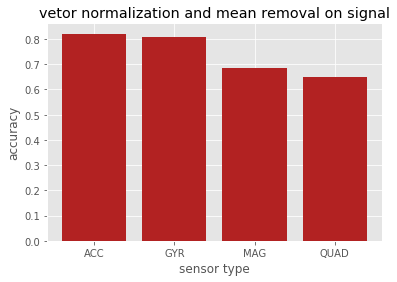

In [27]:
x = ['ACC', 'GYR', 'MAG', 'QUAD']
accuracy = [ACC_accuracy,GYR_accuracy,MAG_accuracy,QUAD_accuracy]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='firebrick')
plt.xlabel("sensor type")
plt.ylabel("accuracy")
plt.title("vetor normalization and mean removal on signal")

plt.xticks(x_pos, x)

plt.show()